<a href="https://colab.research.google.com/github/Samir-atra/BDSD_Minor_Project/blob/main/MediaPipe_Stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download and install packages
# !python -m pip install mediapipe
# !wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
# !wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

# Imports
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import cv2
# from google.colab.patches import cv2_imshow
import csv
import pandas as pd
import tensorflow as tf
# import albumentations as A
import math
import time
from sklearn.preprocessing import MinMaxScaler


2024-04-20 05:28:21.507438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 05:28:26.087450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# MediaPipe visualizations


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()


In [3]:
# a function to write to csv files
def csv_writer(filename, fields, data):

    csvfile = filename
    fields = fields
    with open(csvfile, mode="a") as first:
        csvwriter = csv.writer(first)
        csvwriter.writerow(fields)
        csvwriter.writerows(data)

        return True

In [4]:
# download and upload images
# download
# img = cv2.imread("images.jpg")
# cv2_imshow(img)

#upload
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

I0000 00:00:1713583716.233633   38649 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1713583716.274589   38649 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


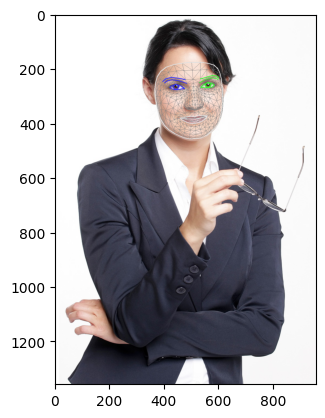

In [5]:
#inferencing and visualizing

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
# print(detection_result.facial_transformation_matrixes)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
img = plt.imshow(annotated_image)
plt.show()
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

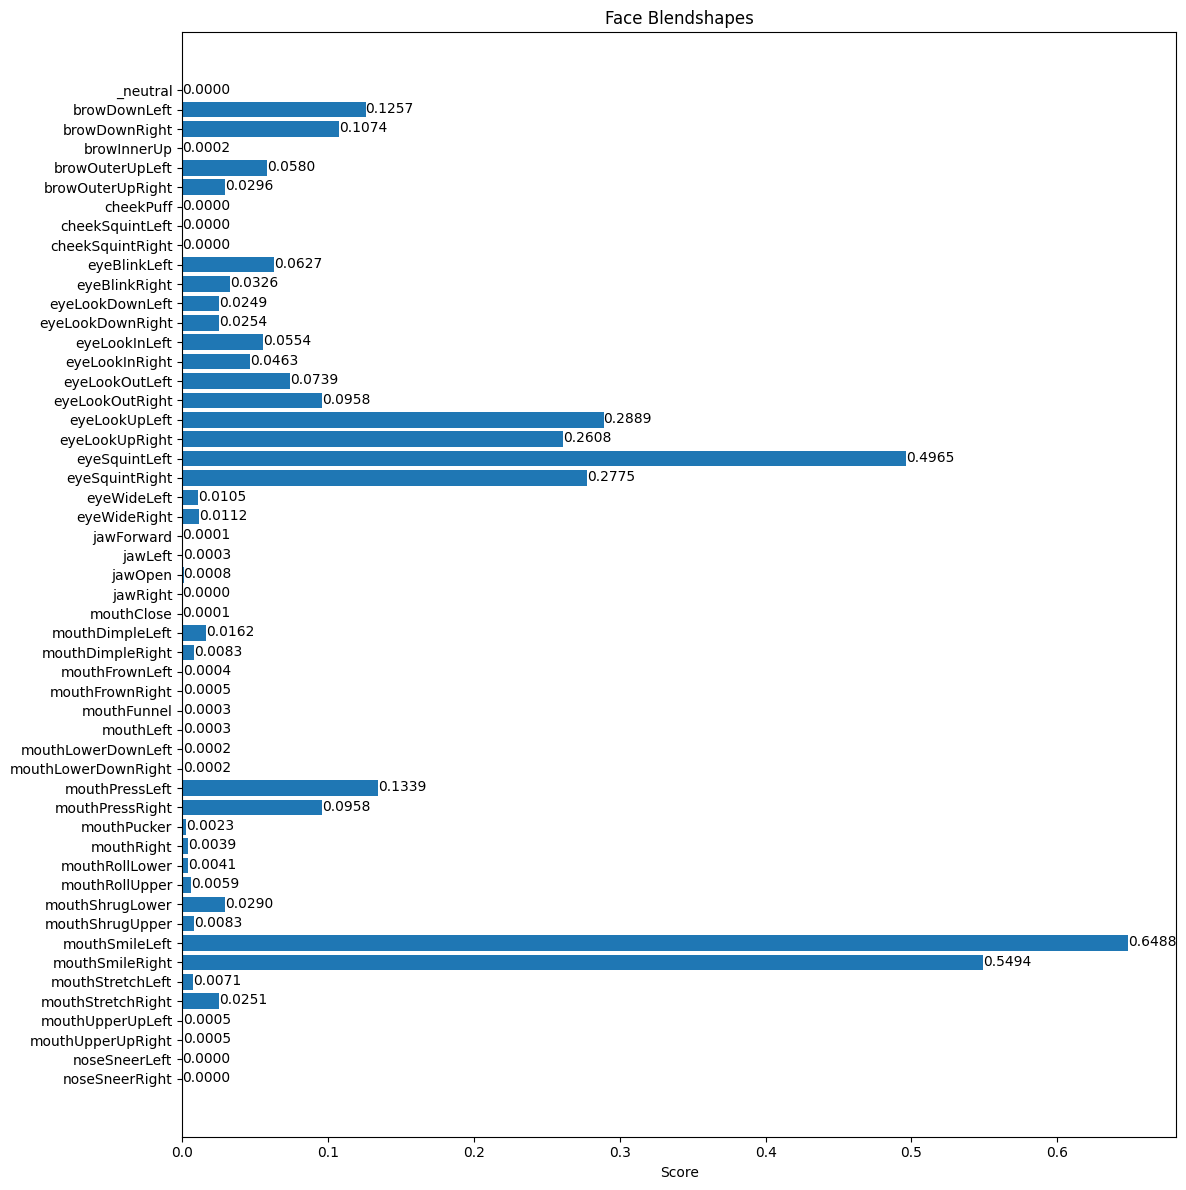

[Category(index=0, score=2.72534475698194e-06, display_name='', category_name='_neutral'), Category(index=1, score=0.1256559193134308, display_name='', category_name='browDownLeft'), Category(index=2, score=0.10741737484931946, display_name='', category_name='browDownRight'), Category(index=3, score=0.0001509089197497815, display_name='', category_name='browInnerUp'), Category(index=4, score=0.05803173407912254, display_name='', category_name='browOuterUpLeft'), Category(index=5, score=0.029591243714094162, display_name='', category_name='browOuterUpRight'), Category(index=6, score=3.763052154681645e-05, display_name='', category_name='cheekPuff'), Category(index=7, score=2.0550255896978342e-07, display_name='', category_name='cheekSquintLeft'), Category(index=8, score=2.673677101938665e-07, display_name='', category_name='cheekSquintRight'), Category(index=9, score=0.06272834539413452, display_name='', category_name='eyeBlinkLeft'), Category(index=10, score=0.03263695165514946, displa

In [6]:
# plot bar graphs

plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
print(detection_result.face_blendshapes[0])

In [7]:
# Processing, cleaning and visualizing the dataset
# dataset = []
# Training_set = []
# validation_set = []
# test_set = []
# categories_count = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}
# skipped = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}

# with open("fer2013.csv", mode= "r") as data:
#   csvFile = csv.reader(data)
#   for lines in csvFile:
#       if lines[0] == "3" or lines[0] == "4" or lines[0] == '6':
#         dataset.append(lines)
  # # iterate over the training dataset
  # for i in range(len(Training_set)):
    # print(categories_count[Training_set[i][0]])
    # categories_count[Training_set[i][0]] = categories_count[Training_set[i][0]] + 1
    # image = np.array(Training_set[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
    # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # print(image.shape)
    # rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
    # detection_result = detector.detect(rgb_frame)
    # print("emotion = ", Training_set[i][0])
    # img = plt.imshow(image)
    # plt.show()
    # # Skip and delete the image if not understood by mediapipe
    # if detection_result.face_blendshapes == []:
    #   skipped[Training_set[i][0]] = skipped[Training_set[i][0]] + 1
    # else:
    #   img = plt.imshow(image)
    #   plt.show()
  #     continue

  # print("This is categories count", categories_count)
  # print("This is skipped", skipped)


# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
# annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))



In [8]:
# cleaning the dataset

# training_set = []
# validation_set = []
# test_set = []

# for i in dataset:
#     if i[2] == 'Training':
#         training_set.append(i)
#     elif i[2] == 'PublicTest':
#         validation_set.append(i)
#     elif i[2] == 'PrivateTest':
#         test_set.append(i)

# training_set_hns = []
# validation_set_hns = []
# test_set_hns = []

# for lines in training_set:
#       image = np.array(lines[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#       image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     #   plt.imshow(image)
#     #   plt.show()
#       frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
#       detection_result = detector.detect(frame)
#       if detection_result.face_blendshapes == []:
#         continue
#       else:
#         training_set_hns.append(lines)

# for liness in validation_set:
#       imagee = np.array(liness[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#       imagee = cv2.cvtColor(imagee, cv2.COLOR_GRAY2RGB)
#     #   plt.imshow(image)
#     #   plt.show()
#       framee = mp.Image(image_format=mp.ImageFormat.SRGB,data=imagee)
#       detection_result = detector.detect(framee)
#       if detection_result.face_blendshapes == []:
#         continue
#       else:
#         validation_set_hns.append(liness)

# for linesss in test_set:
#       imageee = np.array(linesss[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#       imageee = cv2.cvtColor(imageee, cv2.COLOR_GRAY2RGB)
#     #   plt.imshow(image)
#     #   plt.show()
#       frameee = mp.Image(image_format=mp.ImageFormat.SRGB,data=imageee)
#       detection_result = detector.detect(frameee)
#       if detection_result.face_blendshapes == []:
#         continue
#       else:
#         test_set_hns.append(linesss)

# fields = ["emotion", "pixels", "Usage"]
# csv_writer("training_set_hns.csv", fields, training_set_hns)
# csv_writer("validation_set_hns.csv", fields, validation_set_hns)
# csv_writer("test_set_hns.csv", fields, test_set_hns)


In [9]:
# Augmenting images


# augmented_training_set = []
# training_images = []
# training_labels = []
# print(len(Training_set))

# for i in range(math.floor(len(training_set_hns))):
#     image = np.array(training_set_hns[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     training_images.append(image)
#     training_labels.append(int(training_set_hns[i][0]))


# # rescaling and augmenting images models
# rescaling1 = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255)
# ])

# rescaling2 = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1.*255)
# ])

# augment = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomRotation(0.1)
# ])

# for ele in range(len(training_images)):
# # scale down the image and augment
#   img = training_images[ele]
#   label = training_labels[ele]
#   image = rescaling1(img)
#   aug_image = augment(image)
#   # scale up the image cast to an integer and transform into a numpy array
#   aug_image = rescaling2(aug_image)
#   aug_image = tf.cast(aug_image, tf.uint8)
#   aug_image = np.array(aug_image)
#   flatten_image = aug_image.flatten()
#   flat_aug_image = [flatten_image[i] for i in range(0,len(flatten_image),3)]
#   # flattt = np.reshape(flat_aug_image,(48,48))
#   # plt.imshow(flattt)
#   # plt.show()
#   frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=aug_image)
#   detection_result = detector.detect(frame)
#   if detection_result.face_blendshapes == []:
#     continue
#   else:
#     element = [training_labels[ele]]
#     for i in flat_aug_image:
#       element.append(i)
#     augmented_training_set.append([element[0],str(element[1:]).replace(',',"").replace('[','').replace(']',''),'Training'])

# csv_writer("training_set_hns.csv", ['emotion','pixels'], augmented_training_set)

# print(detection_result.face_blendshapes[0])
# annotated_image = draw_landmarks_on_image(frame.numpy_view(), detection_result)
# plt.imshow(annotated_image)
# plt.show()



In [10]:
# choosing relevant blendshapes
# blendS_to_print = ['1', '2', '3', '4', '5', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '25', '30', '31', '34', '35', '36', '37', '38', '40', '42', '44', '45', '46', '47', '48', '49', 'emotion']

# blend_shapes = dict()
# for i in range(0,52):
#     blend_shapes[str(i)] = 0

# print(blend_shapes)
# sad = 0
# happy = 0
# counter = 0

#   # find which blendshapes are most relevant to happiness and sadness
# for i in range(len(training_set_hns)):
#     image = np.array(training_set_hns[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
#     detection_result = detector.detect(frame)
#     if detection_result.face_blendshapes == []:
#         continue
#     else:
#         counter += 1
#     if counter %500 == 0:
#         time.sleep(5)
#     for i in detection_result.face_blendshapes[0]:
#         if i.score > 0.4:
#             blend_shapes[str(i.index)] = blend_shapes[str(i.index)] + 1
# print(blend_shapes)

# detect annotate and plot blendshapes for the image
# frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=aug_image)
# detection_result = detector.detect(frame)
# annotated_image = draw_landmarks_on_image(frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [11]:
# if-else classification

# if detection_result.face_blendshapes[0][44].score > 0.5 and detection_result.face_blendshapes[0][45].score > 0.5 :
#   print("Happy")
# elif detection_result.face_blendshapes[0][42].score > 0.5:
#   print("Sad")


In [ ]:

# creating blendshapes dataset

training_set = []
training_images = []
training_labels = []

blendS_to_print = ['1', '2', '3', '4', '5', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '25', '30', '31', '34', '35', '36', '37', '38', '40', '42', '44', '45', '46', '47', '48', '49', 'emotion']
with open("training_set_hns.csv", mode= "r") as data:
  csvFile = csv.reader(data)
  next(csvFile)
  for lines in csvFile:
    training_set.append(lines)
  print(training_set[0])
  for i in range(len(training_set)):
    print(training_set[i][1])
    image = np.array(training_set[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    training_images.append(image)
    training_labels.append(int(training_set[i][0]))

arr = np.zeros((len(training_images), 33))

print(len(training_images))
arr[0,:]= blendS_to_print
for ele in range(len(training_images)-1):
  img = training_images[ele]
  label = training_labels[ele]
  frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=img)
  detection_result = detector.detect(frame)
#   print(detection_result.face_blendshapes[0])
  for category in detection_result.face_blendshapes[0]:
    if str(category.index) in blendS_to_print:
       arr[ele, blendS_to_print.index(f"{category.index}")] = category.score
       arr[ele, 33] = label

    else:
       continue
   #  print(arr)

np.savetxt("blends_train_set.csv", arr, delimiter = ",")

In [ ]:
# LSTM model
blends_set = []
labels_set = []
with open("blends_train_set.csv", mode= "r") as data:
  csvFile = csv.reader(data)
  next(csvFile)
  for lines in csvFile:
      blends_set.append(lines[0:32])
      labels_set.append(lines[33])
blends_set = np.array(blends_set, dtype=np.float64)
labels_set = np.array(labels_set, dtype=np.float64)

# sc = MinMaxScaler()
# X_train = np.reshape(blends_set,(-1,1))
# y_train = np.reshape(labels_set,(-1,1))
# X_train = sc.fit_transform(blends_set)
# y_train = sc.fit_transform(y_train)
# print(X_train.shape)
#Training LSTM

#Reshaping Array
X_train = np.reshape(blends_set, (10832, 26,1))




# Initialising the RNN
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units = 26, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)
])

# print(X_train[2])
# print(labels_set[2])
# Compiling the RNN
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate = 0.000004),
            metrics = ['accuracy', 'f1_score'])
# Fitting the RNN to the Training set
model.fit(X_train, labels_set, batch_size = 16, epochs = 300)

In [ ]:
# predict

line = blends_set[0]
blend = line[0:26]
print(type(blend[0]))
blend = np.array(blend, dtype=np.float64)
# blend = np.reshape(blend, (1, -1))
# blendy = sc.fit_transform(blend)
blendy = np.reshape(blend, (1, 26,1))
y_pred = model.predict(blendy)
print(y_pred)
# y_pred = sc.inverse_transform(y_pred)
# print(y_pred)
# model.save('LSTM_model_abit_optimized')